In [364]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
from anomalyDetection import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)
from copy import deepcopy

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=1,
            latent_dims=20,
            n_samples=100,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            first_kernel=288,
            modified=True)

args1 = deepcopy(args)
args2 = deepcopy(args)
args3 = deepcopy(args)
args4 = deepcopy(args)

args5 = deepcopy(args)
args6 = deepcopy(args)
args7 = deepcopy(args)
args8 = deepcopy(args)

args1.modified = False
args2.reduction = False
args3.modified = False 
args3.reduction =False

args4.robust = True
args5.robust = True
args6.robust = True
args7.robust = True

args5.modified = False
args6.reduction = False
args7.modified = False 
args7.reduction =False
args_list = [args, args1, args2, args3, args4, args5, args6, args7]
# for arg in args_list:
#     arg.enc_out = arg.enc_output(arg.modified, arg.reduction)


effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(56, 63), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [392]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer

vaes, vqs = [], []
opt_vaes, opt_vqs = [], []
for args in args_list: 
    vae = Variational_Autoencoder(args,
                                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                                v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                               )
    vaes.append(vae)
    vq = VQ_MST_VAE(args,
                    v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                    v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                    v_quantizer = VQ_Quantizer) #10 5
    vqs.append(vq)
for vae in vaes:
    vae = vae.to(args.device)
    opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577)
    opt_vaes.append(opt_vae)
for vq in vqs:
    vq = vq.to(args.device)
    opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577)
    opt_vqs.append(opt_vq)

# opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
# opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

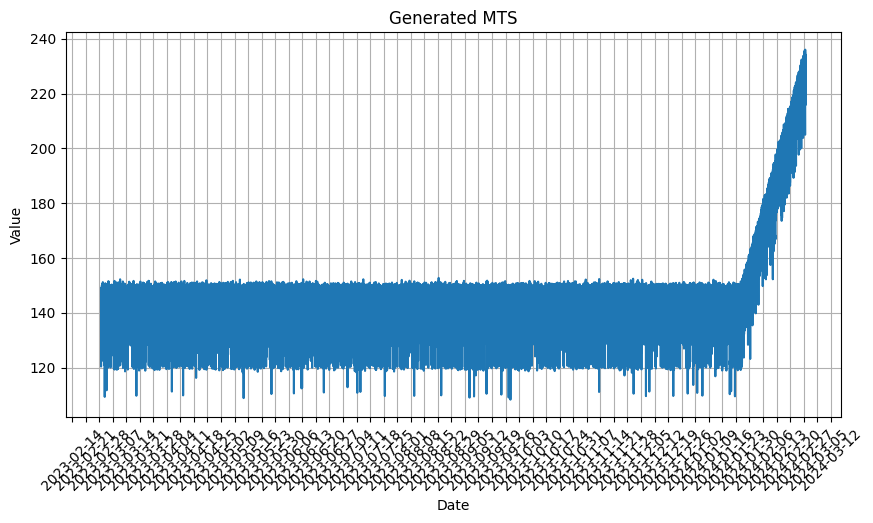

torch.Size([1, 10484])


In [360]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=1,
                                                                            return_gen=True,
                                                                            anomalies=True)

In [361]:
seas = {"occurances":1,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":0.8
        }
trend = {"occurances":1,
        "max_slope":0.002,
        "type":"linear",
        "start":0.8
        }

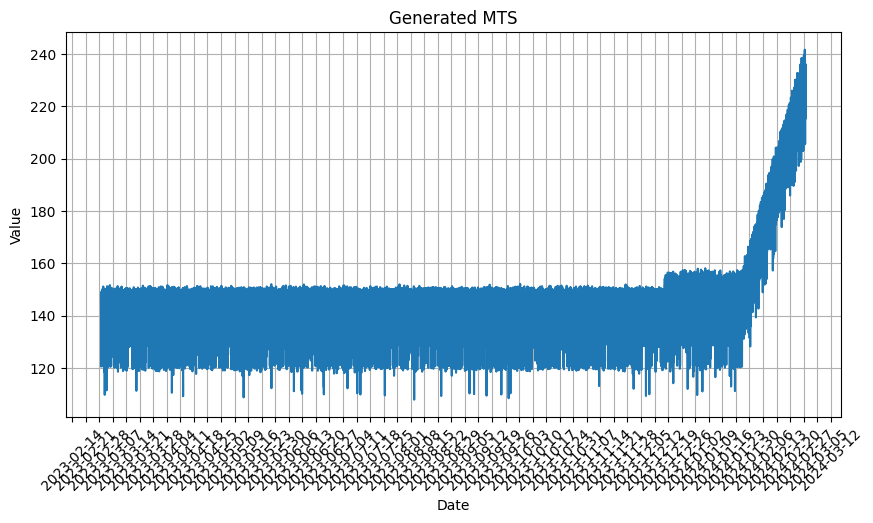

torch.Size([1, 10484])


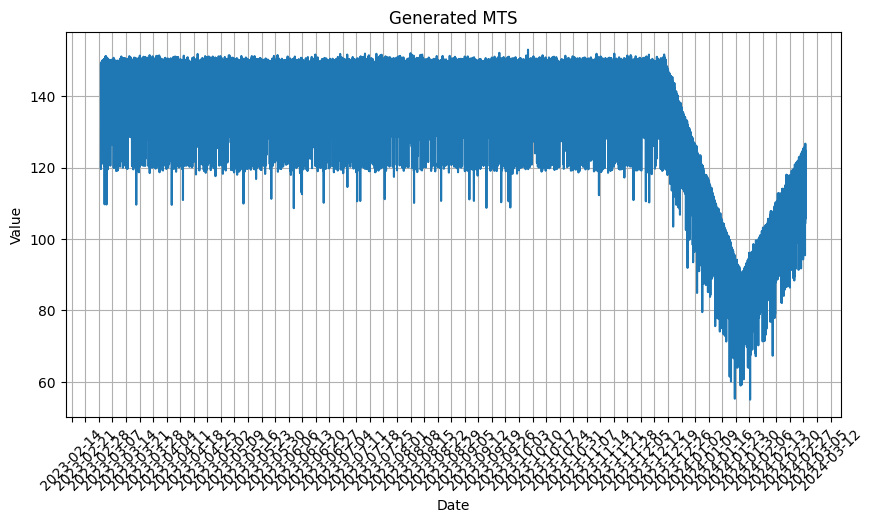

torch.Size([1, 10484])


In [362]:
train_data_long_seas, val_data_long_seas, test_data_long_seas, X_long_seas = add_anomaly_long(X_long, args,
                                                                                              "Seasonality", 
                                                                                              seas, 
                                                                                              return_gen=True)
train_data_long_trend, val_data_long_trend, test_data_long_trend, X_long_trend = add_anomaly_long(X_long, args,
                                                                                              "Trend", 
                                                                                              trend, 
                                                                                              return_gen=True)

In [6]:
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, test_data_long, args, keep_norm=False)
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

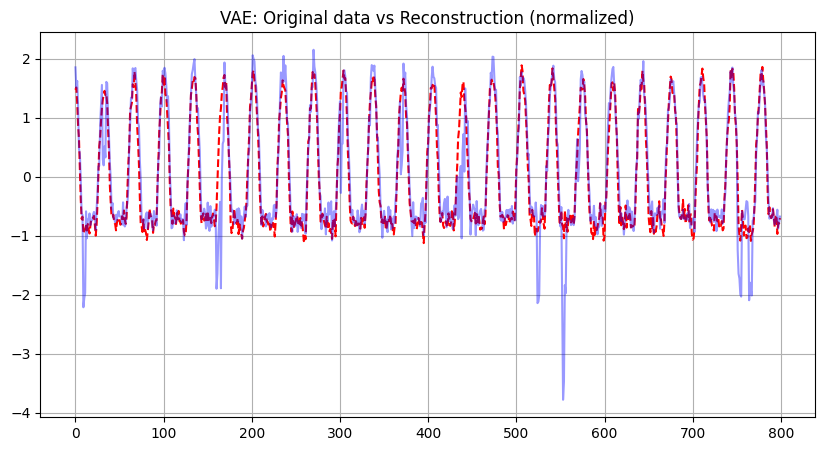

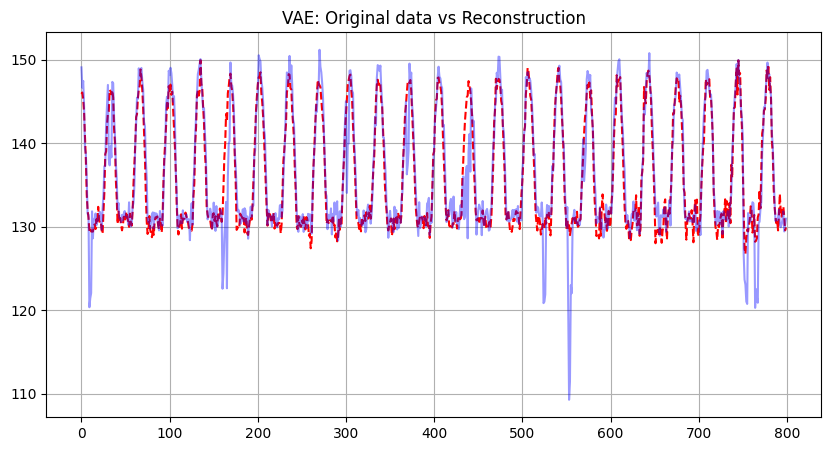

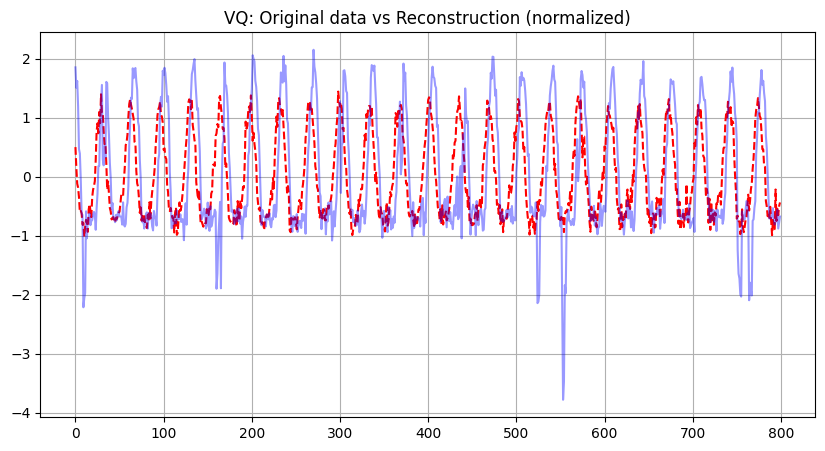

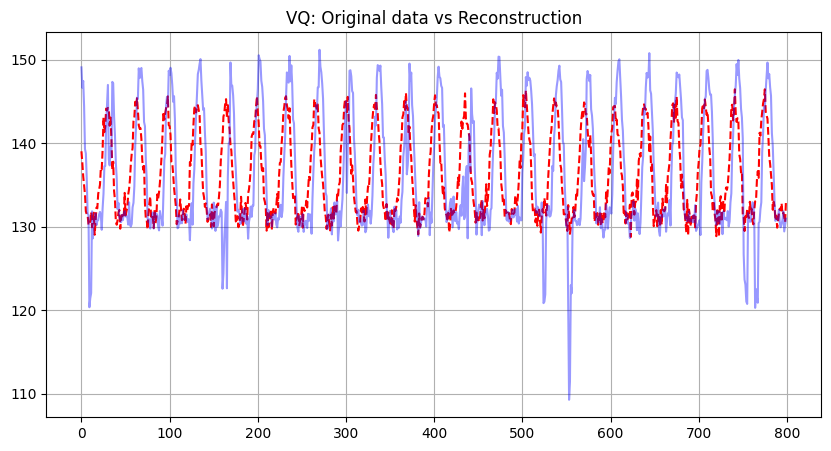

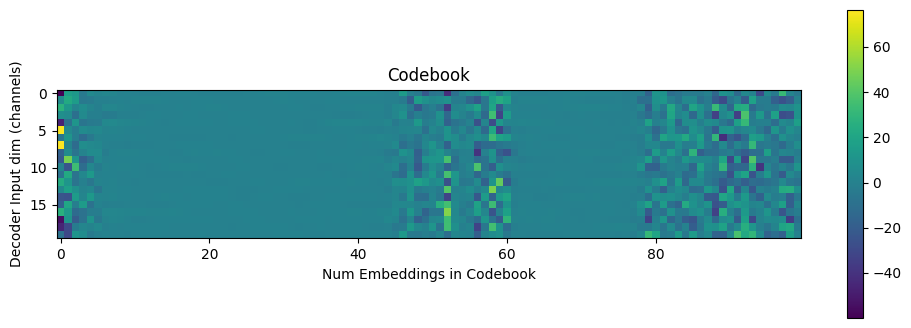

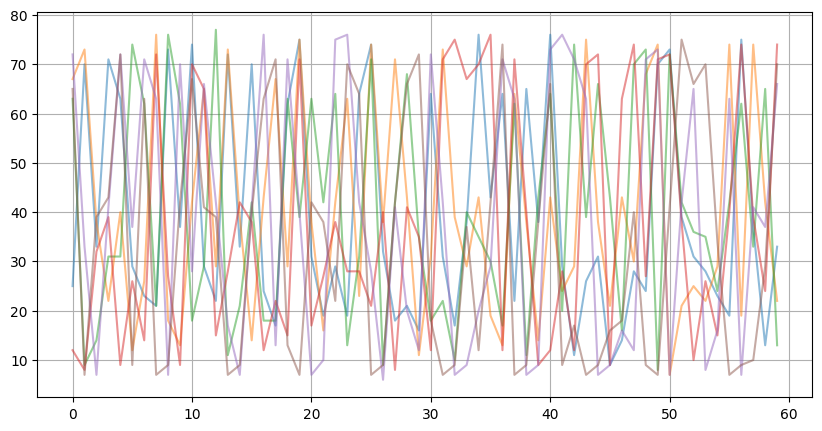

====> VAE: Sample 1 Average loss: 0.5124
====> VQ: Sample 1 Average loss: 1.4820
Train Epoch: 2 [0/1 (0%)]	Loss: 75.264655	 True Loss: 10913.375000
Train Epoch: 2 [0/1 (0%)]	Loss: 209.650485	 True Loss: 30399.320312
====> VAE: Sample 2 Average loss: 0.5191
====> VQ: Sample 2 Average loss: 1.4459
Train Epoch: 3 [0/1 (0%)]	Loss: 74.375471	 True Loss: 10784.443359
Train Epoch: 3 [0/1 (0%)]	Loss: 175.551212	 True Loss: 25454.925781
====> VAE: Sample 3 Average loss: 0.5129
====> VQ: Sample 3 Average loss: 1.2107
Train Epoch: 4 [0/1 (0%)]	Loss: 74.037338	 True Loss: 10735.414062
Train Epoch: 4 [0/1 (0%)]	Loss: 155.418373	 True Loss: 22535.664062
====> VAE: Sample 4 Average loss: 0.5106
====> VQ: Sample 4 Average loss: 1.0719
Train Epoch: 5 [0/1 (0%)]	Loss: 74.533998	 True Loss: 10807.429688
Train Epoch: 5 [0/1 (0%)]	Loss: 151.763712	 True Loss: 22005.738281
====> VAE: Sample 5 Average loss: 0.5140
====> VQ: Sample 5 Average loss: 1.0466
Train Epoch: 6 [0/1 (0%)]	Loss: 74.217295	 True Loss: 1

In [398]:
args.min_max= False
np.set_printoptions(suppress=True)
# VAE_losses = []
# VQ_losses = []
args.robust= False

for epoch in range(1, 20):
#     for i in range(len(vaes)):
    loss_vae = train(vaes[0], train_data_long, args_list[0], opt_vaes[0], epoch)
    loss_vq = train(vqs[0], train_data_long, args_list[0], opt_vqs[0], epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vaes[0], train_data_long, args)
        show_results_long(vqs[0], train_data_long, args, vq=True)
        
#     VAE_losses.append(loss_vae)
#     VQ_losses.append(loss_vq)
                
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

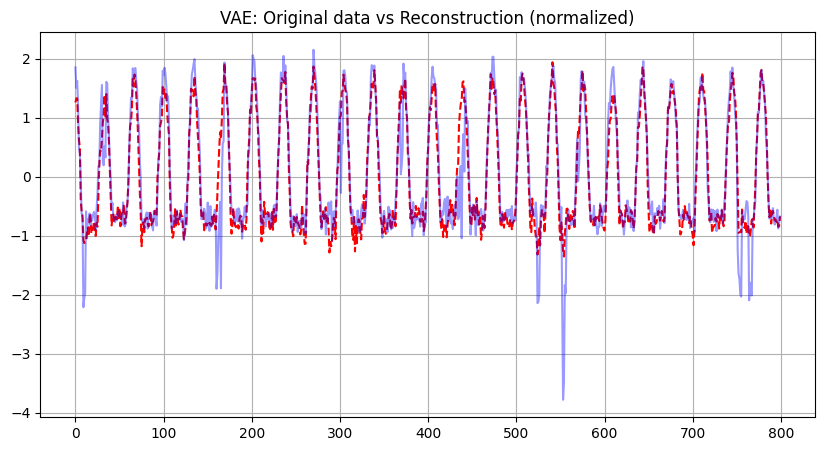

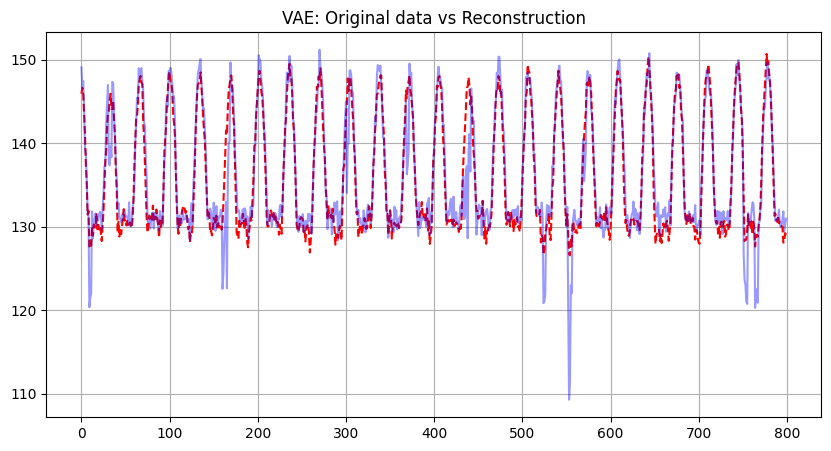

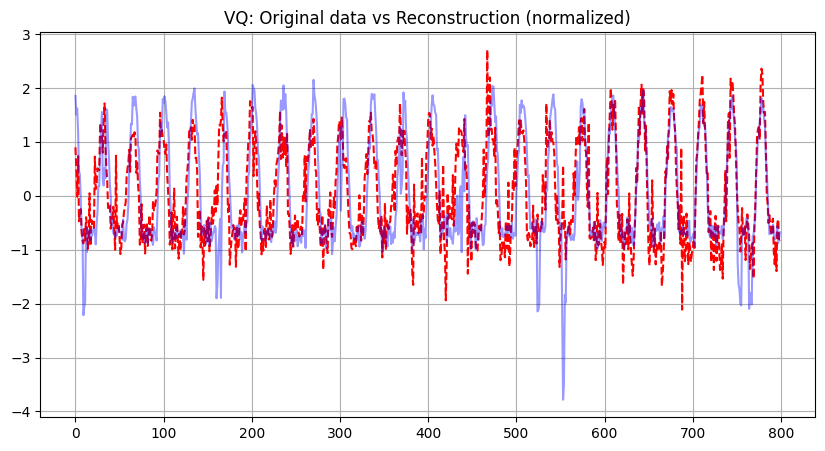

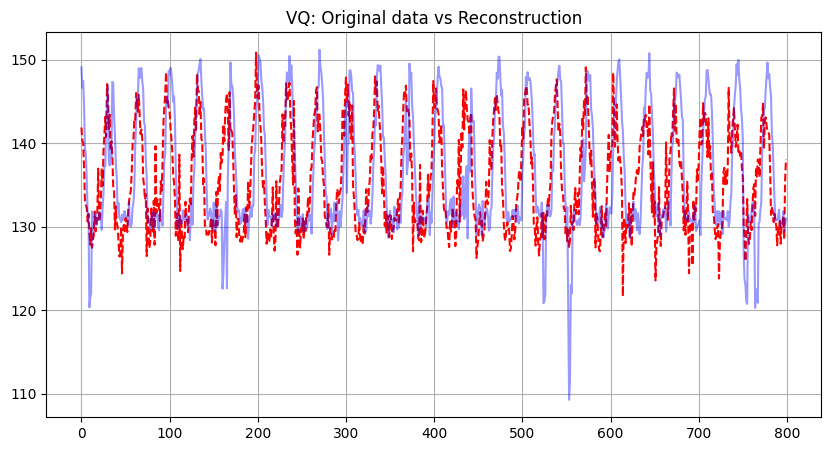

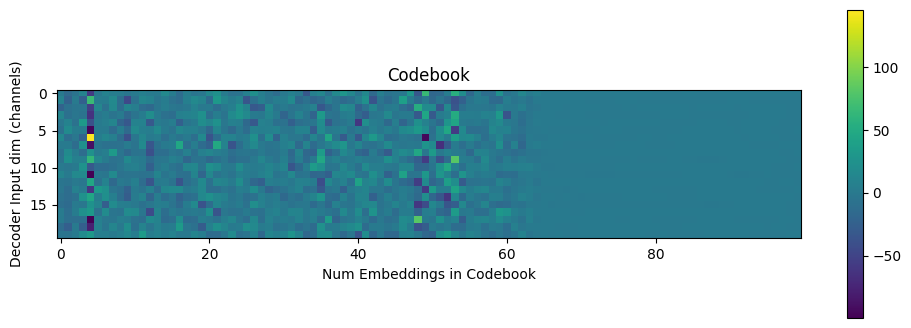

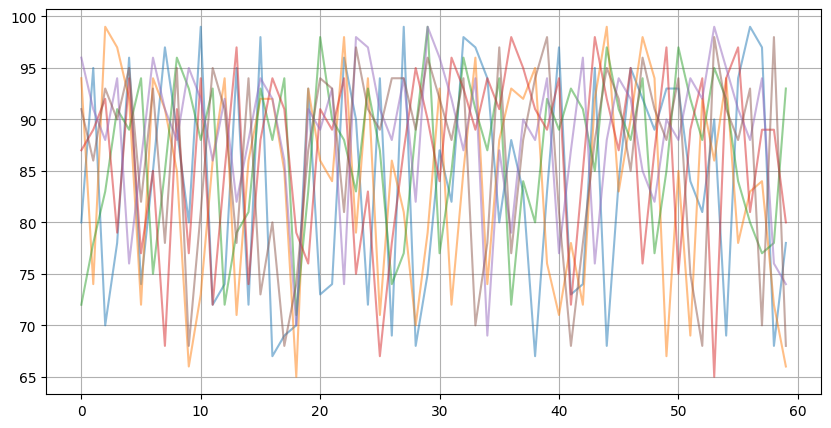

In [385]:
show_results_long(vaes[0], train_data_long, args_list[0])
show_results_long(vqs[0], train_data_long, args_list[0], vq=True)

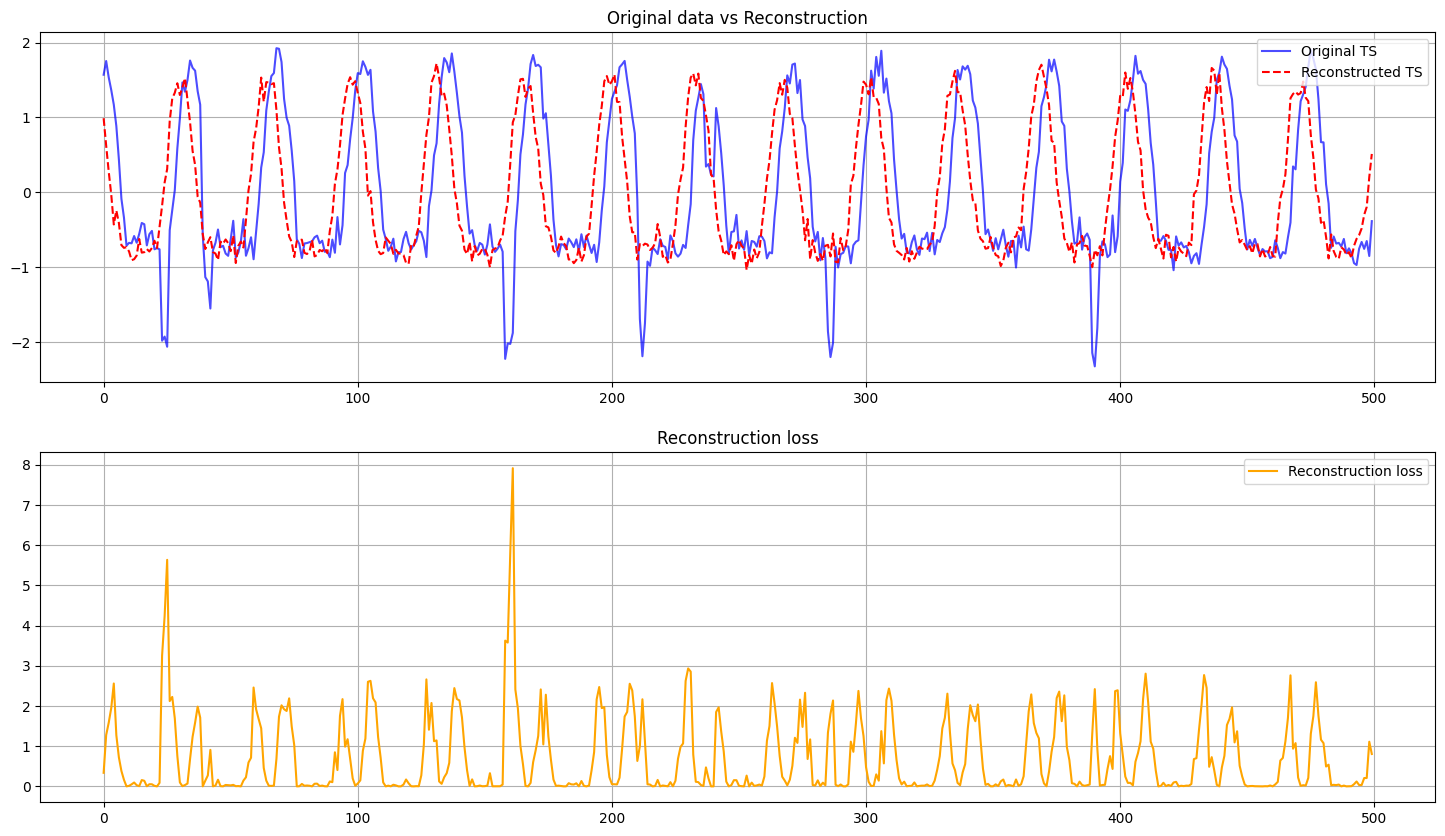

Accuracy:  0.5641396604938271
Recall:  0.6881578947368421
F1 score:  0.3778855421002849


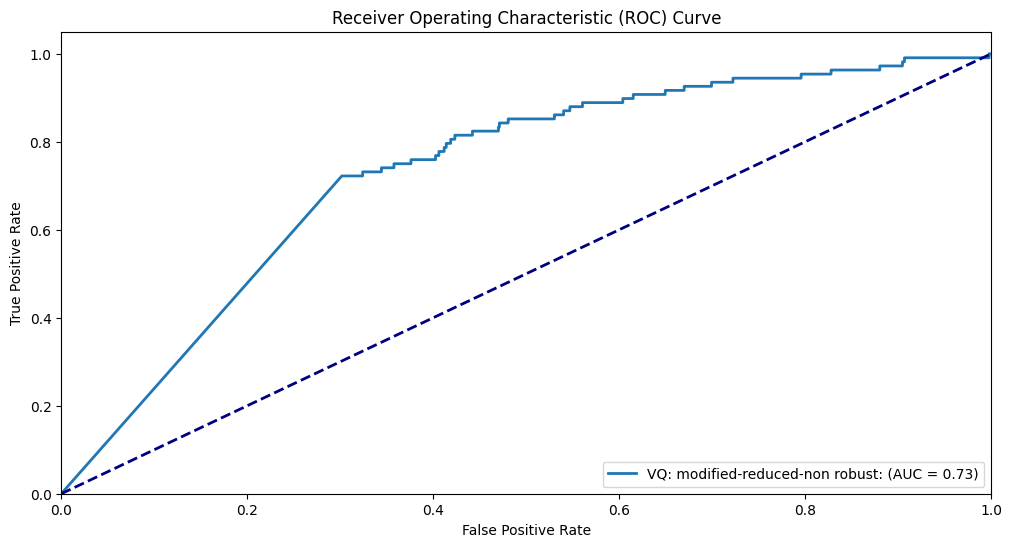

In [399]:
ad = AD(vqs[0], X_long, X_long, args_list[0], test_data_long, norm=True)


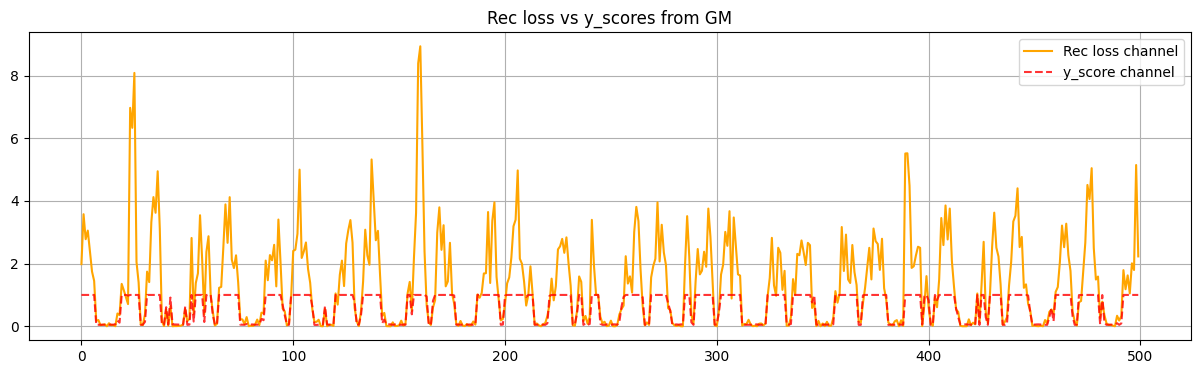

In [391]:
ad.plot_y_scores(ad.rec_loss, ad.y_scores)

Accuracy:  0.6299189814814815
Recall:  0.5655141957511144
F1 score:  0.5508116635314466
VAE: non modified-reduced-non robust (10368,) (10368,) (10368,)
Accuracy:  0.6668595679012346
Recall:  0.6455540075781477
F1 score:  0.6468145360591663
VQ: non modified-reduced-non robust (10368,) (10368,) (10368,)
Accuracy:  0.6345486111111112
Recall:  0.5608484495409691
F1 score:  0.535641560861587
VAE: modified-non reduced-non robust (10368,) (10368,) (10368,)
Accuracy:  0.6654128086419753
Recall:  0.645769466249754
F1 score:  0.6466191110635175
VQ: modified-non reduced-non robust (10368,) (10368,) (10368,)
Accuracy:  0.6120756172839507
Recall:  0.5188996067234976
F1 score:  0.4505086538758025
VAE: non modified-reduced-robust (10368,) (10368,) (10368,)
Accuracy:  0.6298225308641975
Recall:  0.5369514355060897
F1 score:  0.4736145210721482
VQ: non modified-reduced-robust (10368,) (10368,) (10368,)


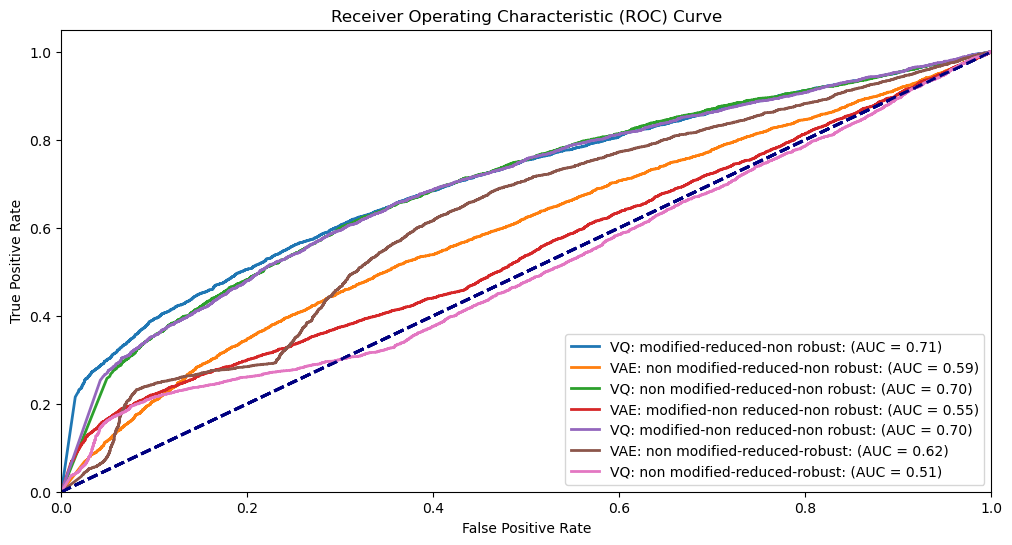

In [176]:
indices =[1,2,5]
for i in indices:
    ad.plot_roc_compare(vaes[i], args_list[i])
    ad.plot_roc_compare(vqs[i], args_list[i])
ad.fig

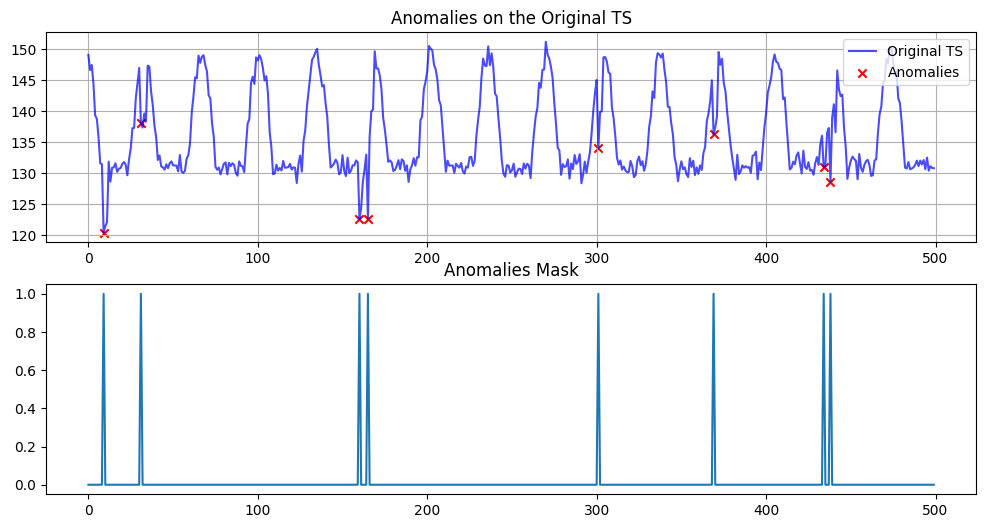

In [375]:
ad.plot_true_anomalies(0, 500)

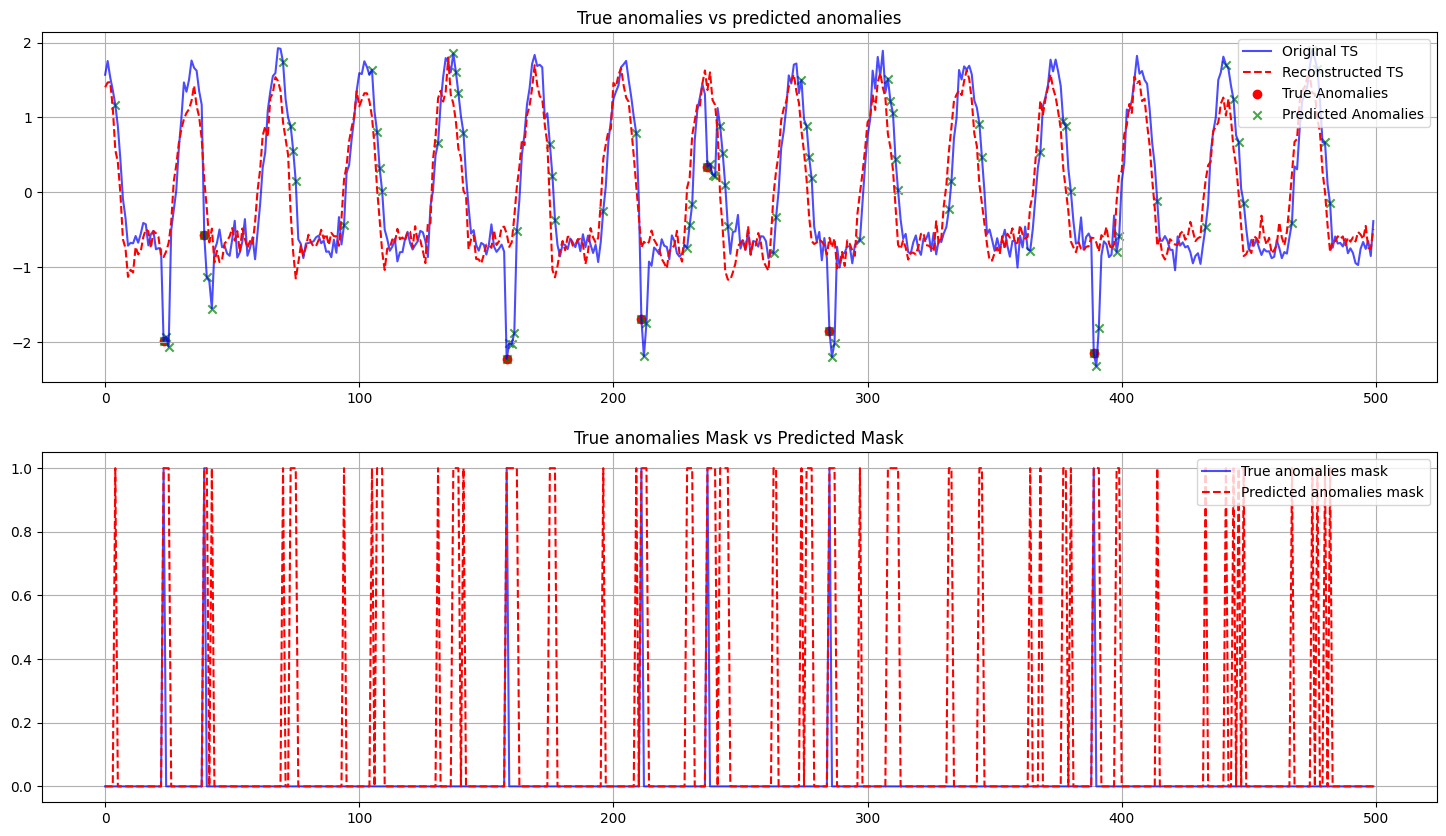

In [388]:
ad.plot_true_pred_anomalies(0, 500)

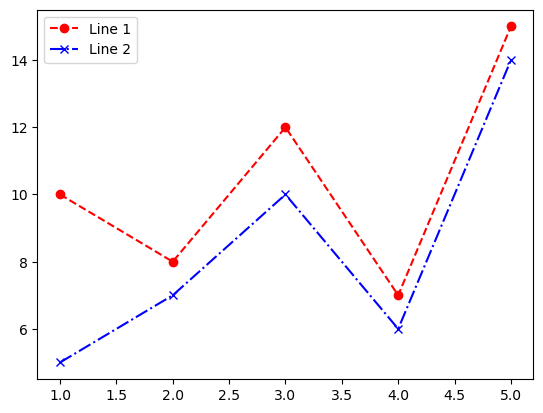

In [111]:
import matplotlib.pyplot as plt

class PlotWithLines:
    def __init__(self):
        # Create a figure and axes in the constructor
        self.fig, self.ax = plt.subplots()

    def add_line(self, x, y, label=None, color=None, linestyle='-', marker=None):
        """
        Add a new line to the existing plot on the Axes object.

        Parameters:
        - x: X-axis values for the new line.
        - y: Y-axis values for the new line.
        - label: The label for the new line (optional).
        - color: The color of the line (optional).
        - linestyle: The line style ('-', '--', '-.', ':', etc.) (optional).
        - marker: The marker style for data points (optional).
        """
        self.ax.plot(x, y, label=label, color=color, linestyle=linestyle, marker=marker)
        self.ax.legend()

# Example usage:
plotter = PlotWithLines()
x_new1 = [1, 2, 3, 4, 5]
y_new1 = [10, 8, 12, 7, 15]
plotter.add_line(x_new1, y_new1, label='Line 1', color='red', linestyle='--', marker='o')

x_new2 = [1, 2, 3, 4, 5]
y_new2 = [5, 7, 10, 6, 14]
plotter.add_line(x_new2, y_new2, label='Line 2', color='blue', linestyle='-.', marker='x')

# Show the plot after all lines are added
# plt.show()


In [109]:
x_new = [1, 2, 3, 4, 5]
y_new = [10, 5, 4, 7, 15]
plotter.add_line(x_new, y_new, label='New Line', color='red', linestyle='--', marker='o')
plt.show()

In [113]:
x_new2 = [1, 2, 3, 4, 5]
y_new2 = [5, 7, 10, 6, 14]
plotter.add_line(x_new2, y_new2, label='Line 2', color='blue', linestyle='-.', marker='x')
